## Define the problem

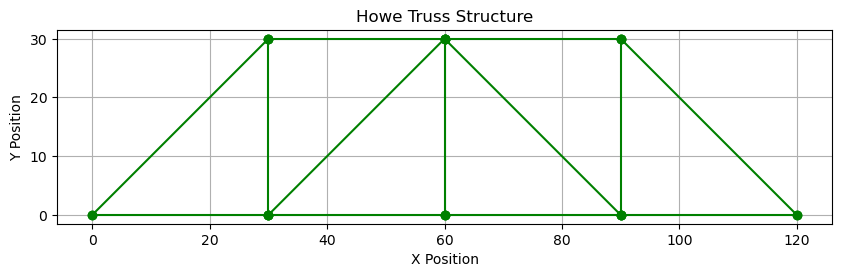

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define system data
L = 30 # ft
I_xx = 1490 # in^4
I_yy = 186 # in^4
E = 29000 # ksi
A = 29.4  # in^2

# Define node coordinates (x, y)
nodes = {
    0: (0, 0), # 0 index my nodes
    1: (L, 0),
    2: (2*L, 0),
    3: (3*L, 0),
    4: (4*L, 0),
    5: (L, L),
    6: (2*L, L),
    7: (3*L, L)
}

members = [
    (5, 6), (6, 7),  # top chords
    (0, 1), (1, 2), (2, 3), (3, 4), # bottom chords
    (0, 5), (1, 5), (1, 6), (2, 6), (3, 6), (3, 7), (4, 7)  # diagonals and verticals
]

# Plot the truss
fig, ax = plt.subplots(figsize=(10, 5))
for member in members:
    n1, n2 = member
    x_vals = [nodes[n1][0], nodes[n2][0]]
    y_vals = [nodes[n1][1], nodes[n2][1]]
    ax.plot(x_vals, y_vals, 'go-')

ax.set_aspect('equal')
ax.set_title("Howe Truss Structure")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
plt.grid(True)
plt.show()


## Write the displacement transformation matrix for each truss member

In [ ]:
def compute_transformation_matrix(n1_coords, n2_coords):
    x1, y1 = n1_coords
    x2, y2 = n2_coords

    dx = x2 - x1
    dy = y2 - y1
    L = np.sqrt(dx**2 + dy**2)

    c = dx / L
    s = dy / L

    # Transformation matrix for a 2D truss element (local to global)
    T = np.array([
        [ c, s, 0, 0],
        [ 0, 0, c, s]
    ])

    return T, L, c, s

transformations = {}
for i, (n1, n2) in enumerate(members):
    T, L_member, c, s = compute_transformation_matrix(nodes[n1], nodes[n2])
    transformations[i] = {
        'nodes': (n1, n2),
        'length': L_member,
        'cosine': c,
        'sine': s,
        'T': T
    }

for i, data in transformations.items():
    print(f"Member {i} (Node {data['nodes'][0]} to {data['nodes'][1]}) Transformation Matrix:")
    display(sym.Matrix(data['T']))
    print()


Member 0 (Node 5 to 6) Transformation Matrix:


Matrix([
[1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0]])


Member 1 (Node 6 to 7) Transformation Matrix:


Matrix([
[1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0]])


Member 2 (Node 0 to 1) Transformation Matrix:


Matrix([
[1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0]])


Member 3 (Node 1 to 2) Transformation Matrix:


Matrix([
[1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0]])


Member 4 (Node 2 to 3) Transformation Matrix:


Matrix([
[1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0]])


Member 5 (Node 3 to 4) Transformation Matrix:


Matrix([
[1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0]])


Member 6 (Node 0 to 5) Transformation Matrix:


Matrix([
[0.707106781186547, 0.707106781186547,               0.0,               0.0],
[              0.0,               0.0, 0.707106781186547, 0.707106781186547]])


Member 7 (Node 1 to 5) Transformation Matrix:


Matrix([
[0.0, 1.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 1.0]])


Member 8 (Node 1 to 6) Transformation Matrix:


Matrix([
[0.707106781186547, 0.707106781186547,               0.0,               0.0],
[              0.0,               0.0, 0.707106781186547, 0.707106781186547]])


Member 9 (Node 2 to 6) Transformation Matrix:


Matrix([
[0.0, 1.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 1.0]])


Member 10 (Node 3 to 6) Transformation Matrix:


Matrix([
[-0.707106781186547, 0.707106781186547,                0.0,               0.0],
[               0.0,               0.0, -0.707106781186547, 0.707106781186547]])


Member 11 (Node 3 to 7) Transformation Matrix:


Matrix([
[0.0, 1.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 1.0]])


Member 12 (Node 4 to 7) Transformation Matrix:


Matrix([
[-0.707106781186547, 0.707106781186547,                0.0,               0.0],
[               0.0,               0.0, -0.707106781186547, 0.707106781186547]])

## Assemble the global stiffness matrix

In [ ]:
# Make units consistant
ft_to_in = 12
dof_per_node = 2
n_nodes = len(nodes)
n_dof = dof_per_node * n_nodes

# Map the DOFs
def get_dof_indices(n1, n2):
    return [
        2 * n1, 2 * n1 + 1,
        2 * n2, 2 * n2 + 1
    ]


# Construct the global stiffness matrix
K_global = np.zeros((n_dof, n_dof))
for i, (n1, n2) in enumerate(members):
    T, L_ft, c, s = compute_transformation_matrix(nodes[n1], nodes[n2])
    L_in = L_ft * ft_to_in

    # Local stiffness in local coords (2x2)
    k_local = (A * E / L_in) * np.array([[1, -1], [-1, 1]])
    T_full = T
    k_global = T_full.T @ k_local @ T_full  # (4x2).T x (2x2) x (4x2)

    dof_idxs = get_dof_indices(n1, n2)
    for a in range(4):
        for b in range(4):
            K_global[dof_idxs[a], dof_idxs[b]] += k_global[a, b]

np.set_printoptions(precision=3, suppress=True)
print("Global Stiffness Matrix K:")
display(sym.Matrix(K_global))


Global Stiffness Matrix K:


Matrix([
[  3205.6656133884,  837.33228005507, -2368.33333333333,               0.0,               0.0,               0.0,               0.0,               0.0,               0.0,              0.0,  -837.33228005507,  -837.33228005507,               0.0,               0.0,               0.0,               0.0],
[  837.33228005507,  837.33228005507,               0.0,               0.0,               0.0,               0.0,               0.0,               0.0,               0.0,              0.0,  -837.33228005507,  -837.33228005507,               0.0,               0.0,               0.0,               0.0],
[-2368.33333333333,              0.0,  5573.99894672174,   837.33228005507, -2368.33333333333,               0.0,               0.0,               0.0,               0.0,              0.0,               0.0,               0.0,  -837.33228005507,  -837.33228005507,               0.0,               0.0],
[              0.0,              0.0,   837.33228005507,   3205.6656133884,    

## Solve the linear system 
in Python and calculate the forces in the truss members. Compare with the result found in Question 4

In [ ]:
# Add in loading conditions
F_global = np.zeros(n_dof)
F_global[3] = -12000
F_global[5] = -12000
F_global[7] = -12000

# Boundary nodes
fixed_dofs = [0, 1, 8, 9]

# Free nodes
all_dofs = np.arange(n_dof)
free_dofs = np.setdiff1d(all_dofs, fixed_dofs)

# Reduce K and F
K_reduced = K_global[np.ix_(free_dofs, free_dofs)]
F_reduced = F_global[free_dofs]

# Solve the system
U_reduced = np.linalg.solve(K_reduced, F_reduced)

# Find the displacments
U_global = np.zeros(n_dof)
U_global[free_dofs] = U_reduced

# Calculate all the forces
member_forces = []
for i, (n1, n2) in enumerate(members):
    data = transformations[i]
    T = data['T']
    L_in = data['length'] * ft_to_in

    k_local = (A * E / L_in) * np.array([[1, -1], [-1, 1]])
    dof_idxs = get_dof_indices(n1, n2)

    u_global = U_global[dof_idxs]

    u_local = T @ u_global
    f_local = k_local @ u_local
    
    axial_force = f_local[1]
    member_forces.append(axial_force)

print("\nAxial Forces in Members:")
for i, force in enumerate(member_forces):
    n1, n2 = members[i]
    print(f"Member {i} (Node {n1}-{n2}): {force:.2f} lb")



Axial Forces in Members:
Member 0 (Node 5-6): -18000.00 lb
Member 1 (Node 6-7): -18000.00 lb
Member 2 (Node 0-1): -3000.00 lb
Member 3 (Node 1-2): 3000.00 lb
Member 4 (Node 2-3): 3000.00 lb
Member 5 (Node 3-4): -3000.00 lb
Member 6 (Node 0-5): -25455.84 lb
Member 7 (Node 1-5): 18000.00 lb
Member 8 (Node 1-6): -8485.28 lb
Member 9 (Node 2-6): 12000.00 lb
Member 10 (Node 3-6): -8485.28 lb
Member 11 (Node 3-7): 18000.00 lb
Member 12 (Node 4-7): -25455.84 lb


## Determine the mid-span deflection 
in the vertical direction. Compare with the results found in questions 2 and 5

In [36]:
mid_span_deflection = U_global[5]
print(f"Mid-span deflection in inches: {mid_span_deflection:.6f} in")
print(f"Mid-span deflection in feet  : {mid_span_deflection / 12:.6f} ft")


Mid-span deflection in inches: -50.196587 in
Mid-span deflection in feet  : -4.183049 ft


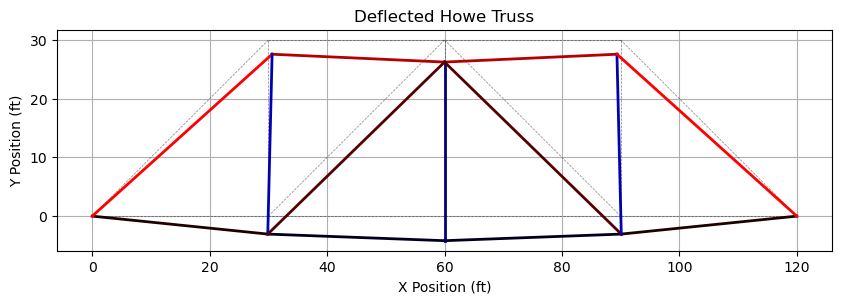

In [37]:
scale = 1 / 12 # forgot to fix units lol

# Find displaced node locations
displaced_nodes = {}
for i in range(n_nodes):
    ux = U_global[2 * i]
    uy = U_global[2 * i + 1]
    x, y = nodes[i]
    displaced_nodes[i] = (x + scale * ux, y + scale * uy)

# Color members
# Red -> compression
# Green -> no force
# blue -> compression
def get_member_color(force, max_force):
    if abs(force) < 1e-3:
        return 'green'
    norm_force = min(abs(force) / max_force, 1.0)
    if force > 0:
        return mcolors.to_hex((0, 0, norm_force))
    else:
        return mcolors.to_hex((norm_force, 0, 0))
max_force = max(abs(f) for f in member_forces)

# Plot undeformed truss
fig, ax = plt.subplots(figsize=(10, 5))
for n1, n2 in members:
    x_vals = [nodes[n1][0], nodes[n2][0]]
    y_vals = [nodes[n1][1], nodes[n2][1]]
    ax.plot(x_vals, y_vals, 'k--', linewidth=0.5, alpha=0.5)

# Plot deformed truss
for i, (n1, n2) in enumerate(members):
    x_vals = [displaced_nodes[n1][0], displaced_nodes[n2][0]]
    y_vals = [displaced_nodes[n1][1], displaced_nodes[n2][1]]
    color = get_member_color(member_forces[i], max_force)
    ax.plot(x_vals, y_vals, color=color, linewidth=2)

ax.set_aspect('equal')
ax.set_title("Deflected Howe Truss")
ax.set_xlabel("X Position (ft)")
ax.set_ylabel("Y Position (ft)")
plt.grid(True)
plt.show()
